Data source: https://www.fragrancenet.com/ : all fragrances.
Web scraping date: 2018/08/03

In [94]:
%matplotlib inline

In [95]:
import gc
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [96]:
fragrance = pd.read_csv('fragrance_reviews_20180803.csv')
print( fragrance.shape )
null_columns=fragrance.columns[fragrance.isnull().any()]
print ( fragrance[null_columns].isnull().sum() )
#print ( fragrance.describe() )
#fragrance[fragrance.product_year.isnull()].head(5)
#fragrance[fragrance.product_note.notnull()].head(5)
#fragrance.product_usage.unique()
#fragrance[ fragrance.product_year == "2000's"]



(27388, 17)
helpful            19802
product_img_ids    13380
product_note        3360
product_price       1270
product_size        2418
product_usage       8259
product_year        3695
rateDate            5600
rating              8850
text                5600
unhelpful          19802
user                5600
dtype: int64


Product_year missing some values. spot check a little bit and see.
The web scraping is correct. Naturally, there are some missing value.

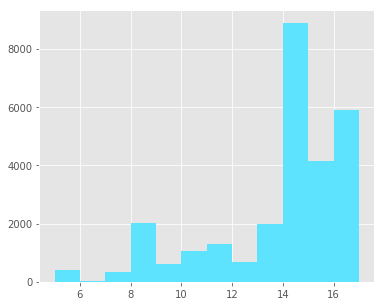

In [97]:
fragrance['full_count'] = fragrance.apply(lambda x: x.count(), axis=1)
fragrance.sort_values(ascending=True , by = 'full_count').head(5)

plt.rcParams['figure.figsize'] = 6,5
graph = plt.hist(fragrance['full_count'], bins=12, color="#5ee3ff")



# Trends!

### Most of the fragrances were created in past 20 years from different design houses.

In [98]:
uniq_product = fragrance.filter(regex=("product.*")).drop_duplicates()

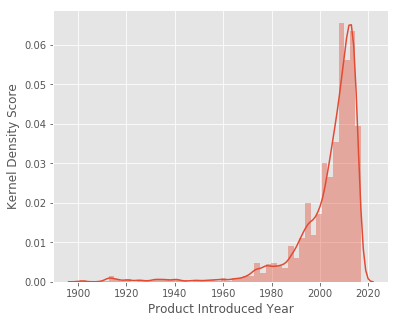

In [99]:
dt = uniq_product['product_year']
dt = dt.dropna()
dt = dt[dt.str.isnumeric()]
dt = dt.apply( pd.to_numeric, errors='ignore' )
dt = sns.distplot(dt[(dt< 2019) & (dt > 1900)])
dt.set(xlabel='Product Introduced Year', ylabel='Kernel Density Score')
plt.show()

## Trends related with prices, types, design houses
![](fragrance_guide.jpg)
image source : https://lifehacker.com/the-real-difference-between-perfume-cologne-toilette-1761347943
- Eau De Parfum and Eau De Toilette are the most abundunt types of the products in the market.
- Eau De Parfum in general is more expensive than Eau De Toilette. This could due to its fragrance concentration within the product.
- The top 20 fragrances producing design houses are what we commonly see at Macy's. e.g. CK, Gucci, Burbarry ..., etc.
- Tom Ford's products (Eau De parfum, Eau De Toilette) are general more expensive than other deisgn houses.
- Kilian and Clive Christian seems to be even high-end perfume brands. They are the luxurious perfume design houses. Quick check on the websites, these two luxurious brands pretty much has no reviews. Normal people probably won't spend money on this. If I have that much money and want to spend that amount of money, I probably won't shop online. However, the fragrance notes are more complex than other fragrances for sure.

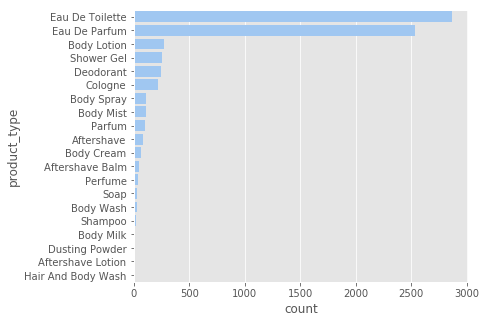

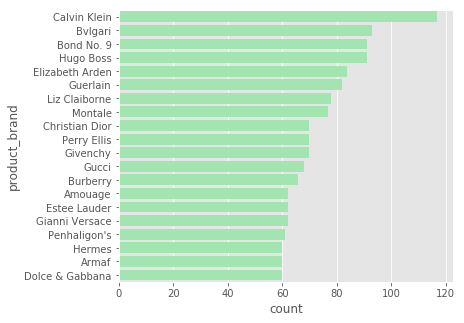

In [100]:
dt = uniq_product[['product','product_brand', 'product_size', 'product_price', 'product_type']].dropna()

# Calculate the unit price for each fragrance.
unit_price = []
for index, row in dt.iterrows():
    size = row['product_size']
    size = [float(i) for i in re.split (",",size) ]
    price = row['product_price']
    price = [float(i) for i in re.split (",",price) ]
    unit_price.append( np.min( np.divide( price , size , dtype=np.float) ) )         
dt['unit_price'] = unit_price

dt_summary = dt.groupby(['product_brand','product_type']).agg({'unit_price': ['count','mean', 'std', 'min', 'max', 'median']})
dt_summary.column_level0 = dt_summary.columns.get_level_values(0)
dt_summary.column_level1 = dt_summary.columns.get_level_values(1)
dt_summary.columns = dt_summary.column_level0 + "_" + dt_summary.column_level1
dt_summary = dt_summary.reset_index().sort_values('product_brand' , ascending=True )

# See the majority of the product types.
majorProductTypes = dt.groupby('product_type').agg({'unit_price': 'count'}).sort_values('unit_price', ascending=False).head(20).reset_index()
majorProductTypes.columns = ['product_type', "count"]
sns.set_color_codes("pastel")
sns.barplot(x="count", y="product_type", data=majorProductTypes,
            label="product_type", color="b")
plt.show()


majorProductTypes = dt.groupby('product_brand').agg({'unit_price': 'count'}).sort_values('unit_price', ascending=False).head(20).reset_index()
majorProductTypes.columns = ['product_brand', "count"]
sns.set_color_codes("pastel")
sns.barplot(x="count", y="product_brand", data=majorProductTypes,
            label="product_brand", color="g")
plt.show()


In [101]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly.graph_objs as go
init_notebook_mode()

#traceCategories = ["Perfume", "Eau De Parfum", "Eau De Toilette", "Cologne", "Eau Fraiche" ]
traceCategories = ["Eau De Parfum", "Eau De Toilette", "Body Lotion", "Cologne", "Perfume" ]

sizeref = 2.*max(dt_summary['unit_price_count'])/(100**2)

trace0 = go.Scatter(
    x=dt_summary['product_brand'][dt_summary['product_type'] == traceCategories[0]],
    y=dt_summary['unit_price_median'][dt_summary['product_type'] == traceCategories[0]],
    mode='markers',
    name=traceCategories[0],
    text=dt_summary['product_brand'][dt_summary['product_type'] == traceCategories[0]],
    marker=dict(
        symbol='circle',
        sizemode='area',
        sizeref=sizeref,
        size=dt_summary['unit_price_count'][dt_summary['product_type'] == traceCategories[0]],
        line=dict(
            width=2
        ),
    )
)

trace1 = go.Scatter(
    x=dt_summary['product_brand'][dt_summary['product_type'] == traceCategories[1]],
    y=dt_summary['unit_price_median'][dt_summary['product_type'] == traceCategories[1]],
    mode='markers',
    name=traceCategories[1],
    text=dt_summary['product_brand'][dt_summary['product_type'] == traceCategories[1]],
    marker=dict(
        symbol='circle',
        sizemode='area',
        sizeref=sizeref,
        size=dt_summary['unit_price_count'][dt_summary['product_type'] == traceCategories[1]],
        line=dict(
            width=2
        ),
    )
)

trace2 = go.Scatter(
    x=dt_summary['product_brand'][dt_summary['product_type'] == traceCategories[2]],
    y=dt_summary['unit_price_median'][dt_summary['product_type'] == traceCategories[2]],
    mode='markers',
    name=traceCategories[2],
    text=dt_summary['product_brand'][dt_summary['product_type'] == traceCategories[2]],
    marker=dict(
        symbol='circle',
        sizemode='area',
        sizeref=sizeref,
        size=dt_summary['unit_price_count'][dt_summary['product_type'] == traceCategories[2]],
        line=dict(
            width=2
        ),
    )
)

trace3 = go.Scatter(
    x=dt_summary['product_brand'][dt_summary['product_type'] == traceCategories[3]],
    y=dt_summary['unit_price_median'][dt_summary['product_type'] == traceCategories[3]],
    mode='markers',
    name=traceCategories[3],
    text=dt_summary['product_brand'][dt_summary['product_type'] == traceCategories[3]],
    marker=dict(
        symbol='circle',
        sizemode='area',
        sizeref=sizeref,
        size=dt_summary['unit_price_count'][dt_summary['product_type'] == traceCategories[3]],
        line=dict(
            width=2
        ),
    )
)

trace4 = go.Scatter(
    x=dt_summary['product_brand'][dt_summary['product_type'] == traceCategories[4]],
    y=dt_summary['unit_price_median'][dt_summary['product_type'] == traceCategories[4]],
    mode='markers',
    name=traceCategories[4],
    text=dt_summary['product_brand'][dt_summary['product_type'] == traceCategories[4]],
    marker=dict(
        symbol='circle',
        sizemode='area',
        sizeref=sizeref,
        size=dt_summary['unit_price_count'][dt_summary['product_type'] == traceCategories[4]],
        line=dict(
            width=2
        ),
    )
)

data = [trace0, trace1, trace2, trace3, trace4]
layout = Layout(
    showlegend=True,
    height=600,
    width=1000,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    yaxis=dict(
        title='Average unit price (USD/oz)',
        gridcolor='rgb(255, 255, 255)',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
        range = [0,350]
    )
)

fig = dict( data=data, layout=layout )

iplot(fig)  

## How to describe a fragrance?

In [237]:
dt = uniq_product[['product','product_brand', 'product_gender', 'product_note', 'product_size', 'product_price' ]].dropna()
note_wo_space = []
unit_price = []
for index, row in dt.iterrows():
    note = row['product_note']
    note_wo_space.append( ','.join( [ x.replace(' ', '_') for x in re.split(', ', note )] ) )
    size = row['product_size']
    size = [float(i) for i in re.split (",",size) ]
    price = row['product_price']
    price = [float(i) for i in re.split (",",price) ]
    unit_price.append( np.min( np.divide( price , size , dtype=np.float) ) )         
dt['unit_price'] = unit_price
dt['product_note'] = note_wo_space
dt[dt.product_note=='evening'].product_note = None  #remove 2 records ... not really a vocabuary.

In [238]:
#Add in additional couple more fragrances from sephora.
sephora = pd.read_csv('../sephora/sephora_fragrance_reviews_20180805.csv')
sephora = sephora.dropna()
sephora.product_note = sephora.product_note.str.replace(".", "")

note_wo_space = []
for index, row in sephora.iterrows():
    note = row['product_note']    
    note_wo_space.append( ','.join( [ x.replace(' ', '_') for x in re.split(', ', note )] ) )
    
sephora['product_note'] = note_wo_space


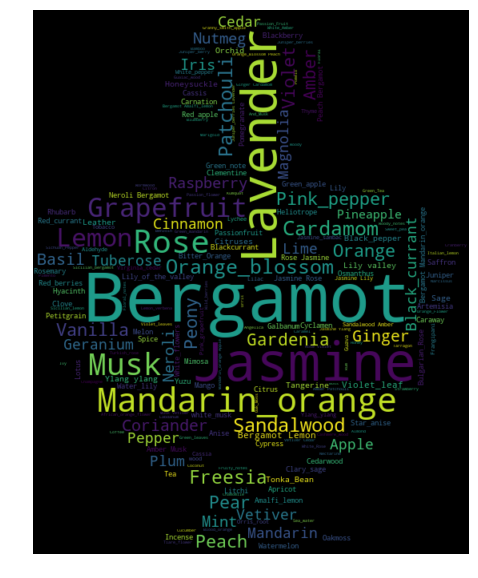

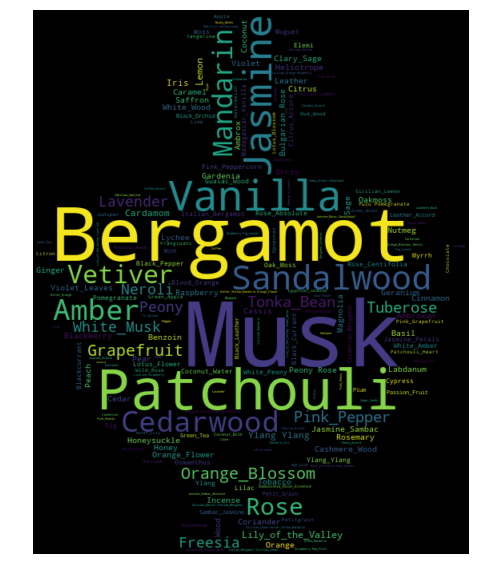

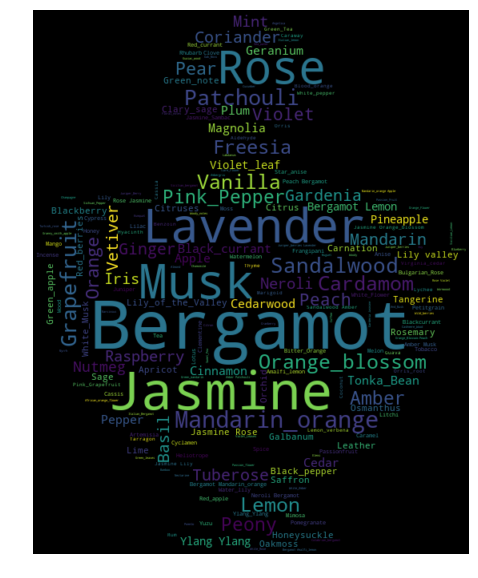

In [239]:
#Show all the fragrance notes in the word cloud
from PIL import Image
from wordcloud import WordCloud

#change the value in return to set the single color need, in hsl format.
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(230,100%%, %d%%)" % np.random.randint(49,51))

text = dt.product_note.str.cat(sep="\n")
img_mask = np.array( Image.open('1716.jpg').convert('LA') )
wc = WordCloud(background_color="black", mask=img_mask).generate(text)
#wc.recolor(color_func = grey_color_func)
# show
plt.rcParams['figure.figsize'] = 10,10
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

text2 = sephora.product_note.str.cat(sep="\n")
wc = WordCloud(background_color="black", mask=img_mask).generate(text2)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

wc = WordCloud(background_color="black", mask=img_mask).generate(text+text2)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Each fragrance has a series of notes describing how does it smell. 
- First, we have to learn the relationships between those words (What is similar. What is not similar.). Based on how they often describe a fragrance, we can use word2vec to estimate the Semantic similarity.
- Second, we can use this model to measure the product similarity and look for similar products with cheaper unit price and suggest it to the buyers. In this case, we didn't count for brand loyality or visual effect of the fragrance.

In [106]:
#combine both website's product_note.
combined_notes = dt.product_note[:].append(sephora.product_note[:])

In [140]:
# Train the model 
import gensim 

def preProcessEachLine(input_data):
    for line in input_data:
        yield gensim.utils.simple_preprocess (line)

documents = list ( preProcessEachLine ( combined_notes ) )

#10 hidden layers, look up -5/+5 window. Drop out words show up less than 2 times. 10 multi-threads 
model = gensim.models.Word2Vec (documents, size=10, window=5, min_count=2, workers=10)  

model.train(documents,total_examples=len(documents),epochs=10000)  #epoch larger to ensure it converge.
len(model.wv.vocab)

1232

In [141]:
w1 = "peach"
print( model.wv.most_similar (positive=w1,topn=6) )

[('indian_mango', 0.884086012840271), ('gardenia', 0.8473040461540222), ('mango', 0.8216084837913513), ('jasmine', 0.7800011038780212), ('apricot', 0.7757952213287354), ('black_currant', 0.7686151266098022)]


In [142]:
w1 = ["peach",'apple','lime']
w2 = ['woody']
print ( model.wv.most_similar (positive=w1, negative=w2, topn=10) )

[('mandarin_orange', 0.8521944284439087), ('black_currant', 0.8487666845321655), ('amalfi_lemon', 0.8119271993637085), ('passionfruit', 0.8074082136154175), ('dew_drops', 0.7795748114585876), ('rhubarb', 0.7661064863204956), ('lotus', 0.7500345706939697), ('hiacynth', 0.7231540679931641), ('spicy_mint', 0.6989452838897705), ('wild_jasmine', 0.6838662028312683)]


In [143]:
print ( model.wv.similarity(w1= "peach",w2= "raspberry") )
print ( model.wv.similarity(w1="peach",w2="sandalwood") )

0.7201625122075745
-0.060540772157063036


In [144]:
print ( model.n_similarity(['peach', 'apple'], ['orange', 'lime']) )
print ( model.n_similarity(['peach', 'apple'], ['sandalwood', 'lime']) )

0.09390437527545464
-0.2051959415859362


In [145]:
def filter_and_return_sim(prod1, prod2):
    prod1 = re.split(",", ''.join(prod1).lower() )
    prod2 = re.split(",", ''.join(prod2).lower() )
    prod1 = list( filter(lambda x: x in model.wv.vocab, prod1) )
    prod2 = list( filter(lambda x: x in model.wv.vocab, prod2) )
    if (len(prod1) == 0): return None
    if (len(prod2) == 0): return None
    return model.n_similarity(prod1,prod2)

In [252]:
TomFord = list( dt.loc[(dt['product'] == 'Tom Ford Grey Vetiver') & (dt['product_gender'] == 'men') ].product_note.unique() ) 
Burberry = list( dt.loc[(dt['product'] == 'Burberry Touch') & (dt['product_gender'] == 'women') ].product_note.unique() ) 
muse = list( dt.loc[(dt['product'] == 'Modern Muse Le Rouge') & (dt['product_gender'] == 'women') ].product_note.unique() )
honeysuckle = list( sephora.loc[ sephora['product'] == 'Mediterranean Honeysuckle'].product_note.unique() )
lightBlue = list( dt.loc[(dt['product'] == 'D & G Light Blue') & (dt['product_gender'] == 'women') ].product_note.unique() )
euphoria = list( dt.loc[(dt['product'] == 'Euphoria') & (dt['product_gender'] == 'women') ].product_note.unique() )


print(TomFord)
print(Burberry)
print(muse)
print(honeysuckle)
print(lightBlue)
print(euphoria)
#print ( filter_and_return_sim(TomFord,Burberry) )
#print ( filter_and_return_sim(TomFord,muse) )
#print ( filter_and_return_sim(muse,Burberry) )
#print ( filter_and_return_sim(honeysuckle,TomFord) )
#print ( filter_and_return_sim(honeysuckle,Burberry) )
#print ( filter_and_return_sim(honeysuckle,muse) )

samples = [TomFord, Burberry, muse, honeysuckle]

['grapefruit,aromatic_sage,orris,orange_blossom,pimiento,oak_moss,amber_woods,nutmeg']
['Orange,Cassia,Cranberry,Blackberry,Red_pepper']
['Red_Currant,Raspberry,Pink_Pepper,Saffron,Bulgarian_Rose']
['Italian_Bergamot,Honeysuckle,Grapefruit,Mandarin_Oil,Jasmine_Sambac_Absolute']
['Apple,Cedar,Bellflower,Sicilian_lemon,White_rose']
['Bergamot,Peach,Green_Notes,Lotus,Orchid']


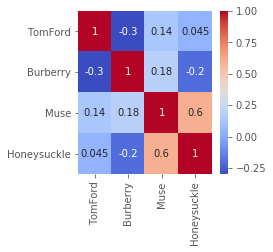

In [147]:
m = np.zeros((4,4)) 
for i, prodi in enumerate(samples):
    for j, prodj in enumerate(samples):
        m[i,j] = filter_and_return_sim (prodi , prodj)
prod_sim = pd.DataFrame ( m )
prod_sim.index = ['TomFord', 'Burberry', 'Muse', 'Honeysuckle']
prod_sim.columns = prod_sim.index
sns.heatmap(prod_sim,cmap="coolwarm",annot=True)
plt.rcParams['figure.figsize'] = 3,3
plt.show()

In [19]:
#The model doesn't seem to be very stable. Probably due to the sample size is small.
dt = dt.reset_index()
prod_sim_matrix = np.zeros((dt.shape[0],dt.shape[0]))
for i, prodi in dt.iterrows():
    for j, prodj in dt.iterrows():
        if i < j:
            prod_sim_matrix[i,j] = filter_and_return_sim(prodi.product_note, prodi.product_note)
dt = dt.set_index('index')

## Reviews analyses

In [186]:
dt = fragrance[['product', 'product_brand', 'product_type','product_gender','product_price','product_size','rateDate', 'rating', 'text']]
dt['text'] = dt['text'].fillna('')
dt['rating'] = dt['rating'].fillna(-1)
dt = dt.dropna()
unit_price = []
for index, row in dt.iterrows():
    size = row['product_size']
    size = [float(i) for i in re.split (",",size) ]
    price = row['product_price']
    price = [float(i) for i in re.split (",",price) ]
    unit_price.append( np.min( np.divide( price , size , dtype=np.float) ) )         
dt['unit_price'] = unit_price

dt.shape[0] / fragrance.shape[0]

0.7632174675040163

In [187]:
from dateutil.parser import parse
#dateObj = parse(fragrance.rateDate[0])  #.strftime('%d/%m/%Y') -- This will give you the reformatted version.
#dateObj.month
dt['rate_month'] = [ parse(x).month for x in dt.rateDate]
dt['rate_year'] = [ parse(x).year for x in dt.rateDate]
dt['rate_day'] = [ parse(x).day for x in dt.rateDate]
dt['rate_year_month'] = [ int( parse(x).strftime('%Y%0m') ) for x in dt.rateDate]

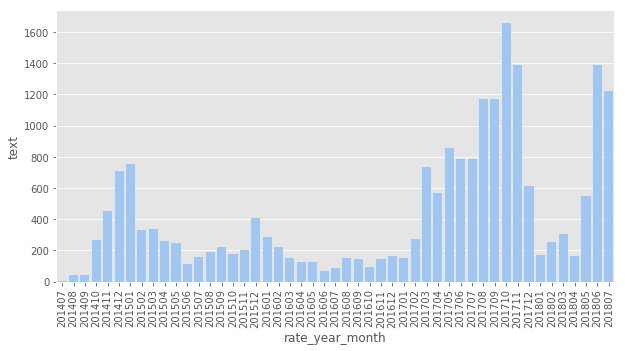

In [188]:
#print( dt['rate_year'].unique() )
#print( dt['rate_month'].unique() )
#print( dt['rate_day'].unique() )
#print( dt['rate_year_month'].unique() )

plt.rcParams['figure.figsize'] = 10,5

Reviews = dt.groupby('rate_year_month').agg({'text': 'count'}).sort_values('rate_year_month', ascending=True).reset_index()
sns.set_color_codes("pastel")
sns.barplot(x="rate_year_month", y="text", data=Reviews, label="rate_year_month", color="b")
plt.xticks(rotation=90)
plt.show()


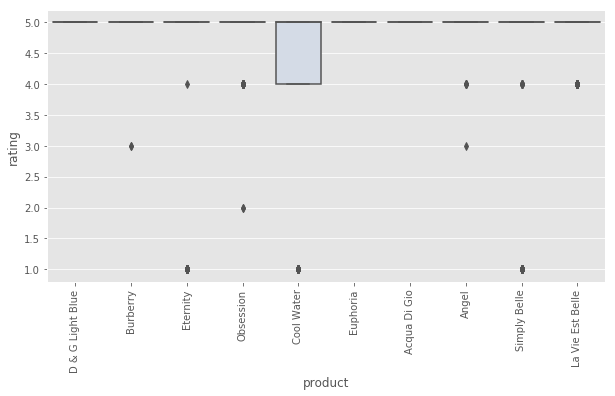

product        product_brand     product_type  rating_count  \
670   D & G Light Blue      Dolce & Gabbana  Eau De Toilette           438   
913           Euphoria         Calvin Klein    Eau De Parfum           220   
27        Acqua Di Gio       Giorgio Armani  Eau De Toilette           186   
901           Eternity         Calvin Klein    Eau De Parfum           180   
2166      Simply Belle  Exceptional Parfums    Eau De Parfum           178   
120              Angel       Thierry Mugler    Eau De Parfum           175   
593         Cool Water             Davidoff  Eau De Toilette           172   
386           Burberry             Burberry    Eau De Parfum           160   
1771         Obsession         Calvin Klein    Eau De Parfum           154   
1454  La Vie Est Belle              Lancome    Eau De Parfum           140   

      rating_mean  rating_median  rating_std  
670      5.000000            5.0    0.000000  
913      5.000000            5.0    0.000000  
27       5.000000            5.0    0.000000  
901      4.200000            5.0    1.604463  
2166     4.286517            5.0    1.496489  
120      5.000000            5.0    0.000000  
593      4.220930            5.0    1.462203  
386      4.975000            5.0    0.222903  
1771     5.000000            5.0    0.000000  
1454     4.800000            5.0    0.401436

In [196]:
dt_summary = dt[ dt['rating'] > 0 ].groupby(['product', 'product_brand', 'product_type']).agg({ 'rating': ['count','mean', 'median', 'std']})
dt_summary.column_level0 = dt_summary.columns.get_level_values(0)
dt_summary.column_level1 = dt_summary.columns.get_level_values(1)
dt_summary.columns = dt_summary.column_level0 + "_" + dt_summary.column_level1
dt_summary = dt_summary.reset_index().sort_values('rating_count' , ascending=False )


#print ( dt_summary.loc[dt_summary['product'] == 'Tom Ford Grey Vetiver'] )
#print ( dt_summary.loc[dt_summary['product'] == 'Burberry Touch'] )
#print ( dt_summary.loc[dt_summary['product'] == 'Modern Muse Le Rouge'] )

prodreviewList_name = dt_summary.head(10)['product'] #If you want the 10 products with the most reviews
# prodreviewList = ['Tom Ford Grey Vetiver', 'Burberry Touch', 'Modern Muse Le Rouge']

subset = dt[ dt['rating'] > 0 ]
prodreview = subset[subset['product'].isin(prodreviewList_name) ]
sns.boxplot(x="product", y="rating", data=prodreview,palette='coolwarm')
plt.xticks(rotation=90)
plt.show()

dt_summary.head(10)

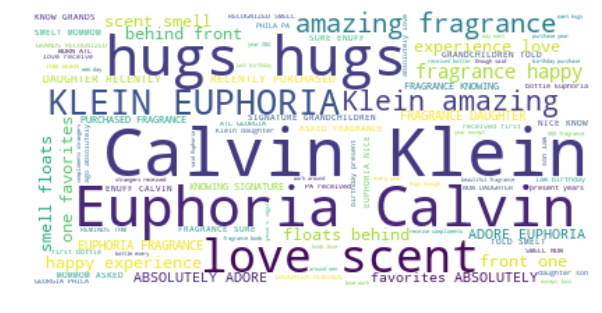

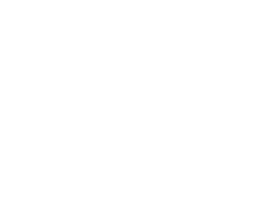

In [235]:
#dg = dt[ (dt['product'] == "D & G Light Blue") & (dt['product_brand'] == 'Dolce & Gabbana' )& (dt['product_type'] == 'Eau De Toilette') ]
dg = dt[ (dt['product'] == "Euphoria") & (dt['product_brand'] == 'Calvin Klein' )& (dt['product_type'] == 'Eau De Parfum') ]

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.append(['Calvin','Klein'])

dg['text'] = dg['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
wc = WordCloud(background_color="white")
# generate word cloud
wc.generate(''.join(dg.text))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(4, 3))
plt.axis("off")
plt.show()